Importing Data and packages

In [58]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

base_der = pd.read_csv('base-case-DER.csv', skiprows=1, usecols=[0, 1, 2, 3], header=None)
base_load = pd.read_csv('base-case-load.csv', skiprows=1, usecols=[0, 1, 2, 3, 4], header=None)
base_line = pd.read_csv('base-case-line.csv', skiprows=1, usecols=[0, 1, 2, 3, 4, 5], header=None)

DERs = set()
CLs = set()

for u in base_der[0]:
    DERs.add(u)

for load, precedance in zip(base_load[0], base_load[1]):
    if precedance == 'Priority':
        CLs.add(load)

Adding edges and weights to graph

In [59]:
G = nx.Graph()
wt = {}
for u, v, w in zip(base_line[0], base_line[1], base_line[3]):
    G.add_edge(u, v)
    wt[(u, v)] = w
    wt[(v, u)] = w
# for n, nbr in G.adjacency():
#     print(n, list(nbr.keys()))

Finding all simple paths from each critical load to each source

In [60]:
path_list = []
for cl in CLs:
    for path in nx.all_simple_paths(G, source=cl, target=DERs):
        loads, sources = 0, 0
        for node in path:
            if node in CLs:
                loads += 1
            if node in DERs:
                sources += 1
        if loads > 1 or sources > 1:
            continue
        path_list.append(list(nx.utils.pairwise(path)))
print(path_list)


[[(17, 16)], [(17, 21), (21, 11), (11, 10)], [(17, 21), (21, 20)], [(7, 6)], [(7, 11), (11, 10)], [(7, 11), (11, 21), (21, 20)]]


Finding All possible combination of paths

In [61]:
cur_comb = set()
all_combs = set()
def comb(path_list, id, cur_comb):
    if len(cur_comb) != 0:
        all_combs.add(tuple(cur_comb))
    for i in range(id, len(path_list)):
        comb(path_list, i + 1, cur_comb)
        for x in path_list[i]:
            x = (min(x), max(x))
            cur_comb.add(x)
        comb(path_list, i + 1, cur_comb)

comb(path_list, 0, cur_comb)
possible_networks = []
for i, x in enumerate(all_combs):
    possible_networks.append(list(x))
    print(f"FN{i + 1}", list(x))

FN1 [(10, 11), (6, 7), (11, 21), (17, 21), (7, 11), (16, 17), (20, 21)]
FN2 [(7, 11), (11, 21), (10, 11), (20, 21)]
FN3 [(10, 11), (6, 7), (11, 21), (7, 11), (20, 21)]
FN4 [(7, 11), (11, 21), (20, 21)]
FN5 [(10, 11), (6, 7), (11, 21), (17, 21), (7, 11), (20, 21)]


### Calculating parameters to measure resiliency of possible network

Ratio of sources to critical loads in the network

In [62]:
def ratio_source_load(possible_networks):
    rsl = []
    for path in possible_networks:
        loads, sources = set(), set()
        for u, v in path:
            if u in CLs:
                loads.add(u)
            if v in CLs:
                loads.add(v)
            if u in DERs:
                sources.add(u)
            if v in DERs:
                sources.add(v)
        if len(loads) == 0:
            rsl.append(0)
            continue
        rsl.append(len(loads)/len(sources))
    return rsl
ratio_source_load(possible_networks)

[0.5, 0.5, 0.3333333333333333, 1.0, 0.6666666666666666]

Total number of switching operations required

In [63]:
def switch_ops(possible_networks):
    ops = []
    for path in possible_networks:
        cnt = 0
        for edge in path:
            if wt[edge] == 0:
                cnt += 1
        ops.append(cnt)
    return ops
switch_ops(possible_networks)

[3, 2, 2, 2, 3]

Aggregated degree centrality of the nodes in the network

In [64]:
def agg_centrality(possible_networks):
    deg_cent = []
    for path in possible_networks:
        G = nx.Graph(path)
        deg = np.average([x for x in nx.degree_centrality(G).values()])
        deg_cent.append(deg)
    return deg_cent
agg_centrality(possible_networks)

[0.25, 0.4, 0.3333333333333333, 0.49999999999999994, 0.2857142857142857]

Calculation of Parameter matrix

In [65]:
rsl = ratio_source_load(possible_networks)
ops = switch_ops(possible_networks)
cen = agg_centrality(possible_networks)

df = pd.DataFrame(np.array([rsl, ops, cen]), columns=[f"FN{i}" for i in range(1, len(rsl)+1)])
df.index = ['rsl', 'ops', 'cen']
df = df.T
print(df)

          rsl  ops       cen
FN1  0.500000  3.0  0.250000
FN2  0.500000  2.0  0.400000
FN3  0.333333  2.0  0.333333
FN4  1.000000  2.0  0.500000
FN5  0.666667  3.0  0.285714


Calculation of weighted mean and resiliency

In [66]:
df['wtd_mean'] = (df['rsl'] * 4 + df['ops'] * 3 + df['cen'] * 3)/10
df['resiliency'] = np.exp(-df['wtd_mean'])
print(df)

          rsl  ops       cen  wtd_mean  resiliency
FN1  0.500000  3.0  0.250000  1.175000    0.308819
FN2  0.500000  2.0  0.400000  0.920000    0.398519
FN3  0.333333  2.0  0.333333  0.833333    0.434598
FN4  1.000000  2.0  0.500000  1.150000    0.316637
FN5  0.666667  3.0  0.285714  1.252381    0.285823


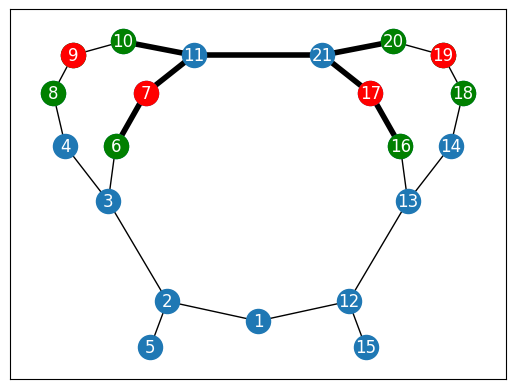

In [67]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, font_color = 'w')
nx.draw_networkx_nodes(G, pos, list(DERs), node_color='g')
nx.draw_networkx_nodes(G, pos, list(CLs), node_color='r')
nx.draw_networkx_edges(G, pos, possible_networks[0], width=4)
plt.show()


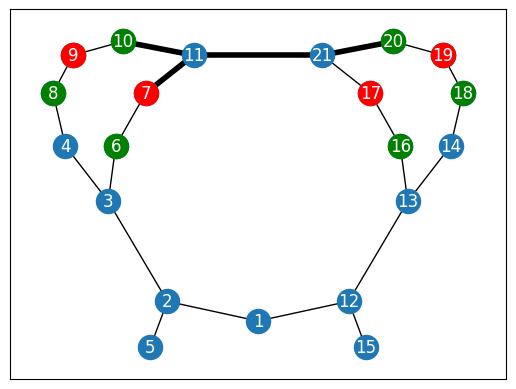

In [68]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, font_color = 'w')
nx.draw_networkx_nodes(G, pos, list(DERs), node_color='g')
nx.draw_networkx_nodes(G, pos, list(CLs), node_color='r')
nx.draw_networkx_edges(G, pos, possible_networks[1], width=4)
plt.show()

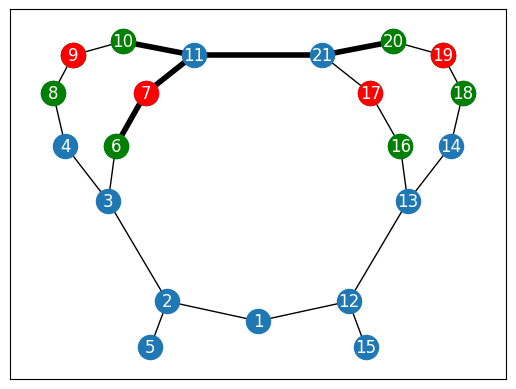

In [69]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, font_color = 'w')
nx.draw_networkx_nodes(G, pos, list(DERs), node_color='g')
nx.draw_networkx_nodes(G, pos, list(CLs), node_color='r')
nx.draw_networkx_edges(G, pos, possible_networks[2], width=4)
plt.show()

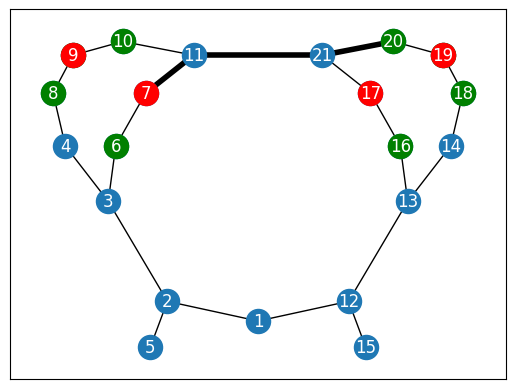

In [70]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, font_color = 'w')
nx.draw_networkx_nodes(G, pos, list(DERs), node_color='g')
nx.draw_networkx_nodes(G, pos, list(CLs), node_color='r')
nx.draw_networkx_edges(G, pos, possible_networks[3], width=4)
plt.show()

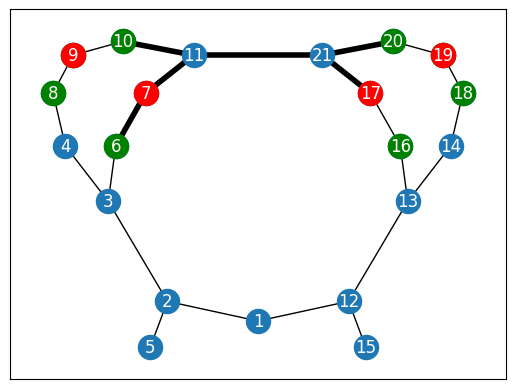

In [71]:
pos = nx.spectral_layout(G)
nx.draw_networkx(G, pos, font_color = 'w')
nx.draw_networkx_nodes(G, pos, list(DERs), node_color='g')
nx.draw_networkx_nodes(G, pos, list(CLs), node_color='r')
nx.draw_networkx_edges(G, pos, possible_networks[4], width=4)
plt.show()